### We create models and flag organizations that seem to struggle based on Program Service Expense ratios

The goal of this mini-project was to create a tool that could flag organisations that were seemingly struggling. We decided to look at the ratio of Program Service Expense (PSE) between subsequent years.
I.e. $SPE_{2011}(O)/SPE_{2010}(O)$ that is much smaller than $E_{\text{ over all O}}(SPE_{2011}/SPE_{2010})$ would be evidence for a struggling organisation $O$ in 2011.

In [1]:
import numpy as np
import pandas as pd
import sys,os,time
import matplotlib.pyplot as plt
import seaborn

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

We import the data and restrict it to fiscal years between 2010 and 2014 (inclusive). We also drop any rows with missing values for the columns we are interested in.

In [3]:
data=pd.read_csv('990Efile+Operational+Data+2009+to+2015.csv', encoding='latin-1')
df1=data[(2010<=data['FISYR']) & (data['FISYR']<=2014)]
df1[['EIN','FISYR','SALARIESCURRENT','TOTEMPLOYEE','TOTALPROGSERVEXP','NteeFinal']].dropna(inplace=True)
data=[]

/home/phrenk/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/phrenk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We perform additional cuts by selecting only the organisations that filed one and only one 990 form for every Fiscal year.

In [4]:
t=df1.groupby('EIN')['FISYR'].count()

atmp={p:1*(t[p]==5) for p in t.keys()}
keep=[bool(atmp[e]) for e in df1['EIN']]
npd=df1[keep]

t2=npd.groupby('EIN')['FISYR'].unique()
atmp={p:1*(len(t2[p])==5) for p in t2.keys()}
keep=[bool(atmp[e]) for e in npd['EIN']]

#Here we add a new column that indexes the year as an integer from 0 to 4
npd=npd[keep]
npd['time']=[int(str(d)[-1]) for d in npd['FISYR']]

We created a dictionary that relates Nteefinal characters to the major groups.

In [5]:
chartocat={}
chartocat['A']=1
chartocat['B']=2
chartocat['C']=3
chartocat['D']=3
chartocat['E']=4
chartocat['F']=4
chartocat['G']=4
chartocat['H']=4
chartocat['I']=5
chartocat['J']=5
chartocat['K']=5
chartocat['L']=5
chartocat['M']=5
chartocat['N']=5
chartocat['O']=5
chartocat['P']=5
chartocat['Q']=6
chartocat['R']=7
chartocat['S']=7
chartocat['T']=7
chartocat['U']=7
chartocat['V']=7
chartocat['W']=7
chartocat['X']=8
chartocat['Y']=9
chartocat['Z']=10

In [6]:
#main columns that we were initially considering. We went with the Program Service Expenses only
cols=['SALARIESCURRENT','TOTEMPLOYEE','TOTALPROGSERVEXP']

We create another variable in our dataframe which holds the group of the EIN

In [7]:
npd['group']=np.array([chartocat[str(Ntee)[0].upper()] for Ntee in npd['NteeFinal']])

We define a few functions that will be useful

In [8]:
def get_ratios(data): #given data, an np.array of size=(n_years,n_organization) containing
                      # expenses for each orgs at every year, we compute the interyear ratios
    nyears=len(data)
    zeros=[]
    for i in range(nyears):
        if(data[i]==0):
            zeros.append(i)
            data[i]=1e-3
    iyr=[data[i+1]/data[i] for i in range(nyears-1)]
    iyr.append(data[-1]/data[0])
    return np.array(iyr)

def func_ratio(npd,c,npd_feat): #given a panda array npd (created above), adds a new column to npd_feat
                                #containing the interyear ratios of the column named 'c' (we will chose SPE)
    orgs_feats=[]
    for e in unE:
        dat_to_analyze=npd[npd['EIN']==e].sort_values('time')
        orgs_feats.append(get_ratios(dat_to_analyze[c].values))
    orgs_feats=np.array(orgs_feats)
    for i in range(len(orgs_feats[0])):
        npd_feat[c+'_ratio_'+str(i+1)]=orgs_feats[:,i]
    return npd_feat

Below runs the above function to get a data set with the ratios

In [9]:
unE=npd['EIN'].unique()
npd_feat=pd.DataFrame(data=unE,columns=['EIN'])
EINgroup=[]
tmp=npd[['EIN','group']]
for e in unE:
    EINgroup.append(tmp[tmp['EIN']==e]['group'].values[0])
npd_feat['group']=EINgroup
npd_feat=func_ratio(npd,cols[2],npd_feat)#cols[2] = 'TOTALPROGSERVEXP'

With this dataset, we can build a model by looking at the mean ratio and its standard deviation throughout the years. Plotting these (done in the financial2 notebook) shows that the log of their value looks fairly like a Gaussian distribution. Hence we will assume the log(ratio) to be a Gaussian variable with mean and standard deviation determined from this sample.

![alt text](ratio_years.png)

In [10]:
def make_models(year_ratio,group):
    models={}
    ugroup=np.unique(group)
    for g in ugroup:
        tmp=np.log(year_ratio[np.where(group==g)[0]])
        models[g]=[np.mean(tmp),np.std(tmp)]
    return models
    

In [11]:
npd_feat.columns

Index(['EIN', 'group', 'TOTALPROGSERVEXP_ratio_1', 'TOTALPROGSERVEXP_ratio_2',
       'TOTALPROGSERVEXP_ratio_3', 'TOTALPROGSERVEXP_ratio_4',
       'TOTALPROGSERVEXP_ratio_5'],
      dtype='object')

In [12]:
model_list=[]


cols=npd_feat.columns
for i in range(4):
    c=cols[2+i]
    #applying cuts to undefined ratios and to remove huge outliers
    l_cutoff=0.1
    h_cutoff=10
    tmp=npd_feat[(npd_feat[c]!=1)& (npd_feat[c]<h_cutoff) & (npd_feat[c]>l_cutoff)]

    year=tmp[c].values
    group=tmp['group'].values
    model_list.append(make_models(year,group))

np.save('model_list',model_list)

With the yearly model parameter saved, we write a function that outputs the quantile of a ratio of SPE given a yearly model.

In [13]:
from scipy.stats import norm as G_V

def query(ratio,model):
    logratio=np.log(ratio)
    quantile=G_V.cdf(logratio, loc=model[0], scale=model[1])
    return quantile

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:

def thresh_to_loss(thres,model):
    return 10**G_V.isf(1-thres,loc=model[0],scale=model[1])

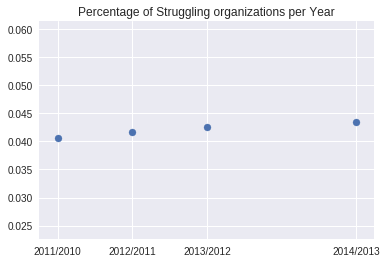

In [16]:
#This is not very interesting; we expect this to be equal to the threshold value due to how we modeled the data.
def yearly_struggle(threshold):
    struggle=[]
    for i in range(4):
        c=cols[2+i]
        tmp=npd_feat
        tmp=tmp[tmp[c]!=1]
        tmp=tmp[tmp[c]<h_cutoff]
        tmp=tmp[tmp[c]>l_cutoff]
        year=tmp[c].values
        group=tmp['group'].values
        struggle_count=0
        for j in range(len(year)):
            model=model_list[i][group[j]]
            if(query(year[j],model)<threshold):
                struggle_count+=1
        struggle.append(struggle_count/len(year))
    return struggle

year_ratio=['2011/2010','2012/2011','2013/2012','2014/2013']
plt.xticks([0,1,2,4], year_ratio)
struggle=yearly_struggle(0.05)
plt.scatter([0,1,2,4],struggle)
plt.title(r'Percentage of Struggling organizations per Year')


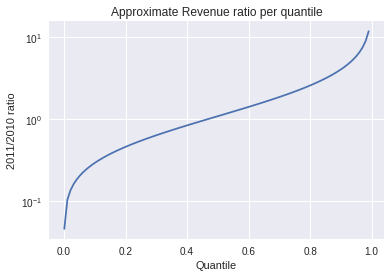

In [17]:
#Shows the relation between SPE ratios and the quantile of the organisation
thres=np.linspace(0.001,0.99,100)
loss=[thresh_to_loss(t,model=model_list[0][1]) for t in thres]
plt.plot(thres,loss)
plt.yscale('log')
plt.title('Approximate Revenue ratio per quantile')
plt.ylabel('2011/2010 ratio')
plt.xlabel('Quantile')

Now we run the query function over the subset of data we've been playing and use its quantile output to make a new variable in the dataset. We first define a new dataframe *orgs_quantile* which will hold the column 'QUANTILE_PSEratio'. This takes a value of NaN if we did not compute the quantity. For instance, this occurs because the fiscal year is 2010 (and we don't have 2009 to take the ratio).  Ignore the warnings.

In [18]:
orgs=npd[['EIN','FISYR','TOTALPROGSERVEXP','group']]
orgs_quantile=npd[['EIN','FISYR','group']]
orgs_quantile.loc[:,'QUANTILE_PSEratio']=np.array([np.NaN for i in range(len(orgs))])

/home/phrenk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/phrenk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
for i in [2011,2012,2013,2014]:
    year0=orgs.loc[orgs['FISYR']==i-1,['TOTALPROGSERVEXP','EIN','group']]
    year0.loc[:,'TOTALPROGSERVEXP']+=1e-3
    year0.set_index(year0['EIN'],inplace=True)
    year1=orgs.loc[orgs['FISYR']==i,['TOTALPROGSERVEXP','EIN','group']]
    year1.loc[:,'TOTALPROGSERVEXP']+=1e-3
    year1.set_index(year1['EIN'],inplace=True)
    r=(year1/year0)
    groups=year1['group'].unique()
    for g in groups:
        model=model_list[int(str(i-1)[-1])][g]
        tmp=r[year1['group']==g]['TOTALPROGSERVEXP'].values
        orgs_quantile.loc[(orgs_quantile['FISYR']==i)&(orgs_quantile["group"]==g),'QUANTILE_PSEratio']=query(tmp,model)


/home/phrenk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/phrenk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/home/phrenk/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/phrenk/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/phrenk/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/home/phrenk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A val

We save the output

In [20]:
orgs_quantile[['EIN','FISYR','QUANTILE_PSEratio']].to_csv('quantile_pse_ratio')

In [21]:
orgs_quantile[['EIN','FISYR','QUANTILE_PSEratio']].tail()

,EIN,FISYR,QUANTILE_PSEratio
1383886,996032457,2014,0.708421
1383887,996035847,2014,0.585466
1383888,996046220,2014,0.462131
1383890,996064620,2014,0.523398
1383892,996078202,2014,0.477344
